In [28]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
import os
import json
import folium
from folium.plugins import HeatMap
from geopy.exc import GeocoderTimedOut
import geopandas as gpd
from geopy.geocoders import Nominatim
import pysal as ps
import geojson as gj
from scipy import stats
from shapely.geometry import Polygon
from sklearn import preprocessing
import warnings
from pysal.contrib.viz import folium_mapping as fm
warnings.filterwarnings('ignore')

ImportError: No module named 'pysal.contrib'

# Smart Parking In Toronto
Anxin (Roxanne) Zhao (1004859478) & Bharadwaj Janarthanan (1005068720) & Seung Eun Yi (1005078782)

## Table of Contents:
* [Introduction](#first-bullet)
* [EDA](#second-bullet)
* [Modeling](#third-bullet)
* [Next steps](#fourth-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>


The main problem we would like to solve is how to help municipalities optimize parking in Toronto. It can be done by reducing parking time of the vehicles at an individual level, or by finding optimal areas to place new parking locations for commercial vehicles. We decided therefore to split the problem into two main parts, one for individual vehicles and one for general organization.

* For individual vehicles, we would like to look at **how we could optimize parking time**. We want to identify free parking spots, and provide an optimal route for vehicles looking for parking by defining and optimizing our own "distance" metric.

* At a general organizational level, we want to see if **we can place new facilities to save parking time for vehicles**. We want to identify locations where the vehicles spend most time in before finding a parking spot, and look closer at how vehicle movement is different in different neighborhoods.

## EDA <a class="anchor" id="second-bullet"></a>

### I. Individual vehicles: how do we optimize parking time?

#### How do we identify free parking spots?

To answer this question, we look at Green P Parking and On-Street parking permit areas to identify parking slots in each geoHash. We compare the total available slots to the total number of vehicles searching for parking.

In [12]:
df_gpp_geohash = pd.read_csv('../data/gpp_cleaned_except_rate_details.csv')
df_plf_geohash = pd.read_csv('../data/parking_lot_facilities_geohash.csv')

In [14]:
df_gpp_geohash.rename({'lat': 'latitude', 'lng':'longitude'}, axis=1, inplace=True)
total_parking = pd.merge(df_gpp_geohash, df_plf_geohash, how='outer', on='geohash')
total_parking.fillna(0, inplace=True)
total_parking['total_spots'] = np.maximum(total_parking['parking_spots'], total_parking['capacity'])
total_parking.rename({'geohash': 'Geohash'},axis=1, inplace=True)

In [2]:
df_geotab = pd.read_csv('../data/SearchingForParking_Toronto.csv')

In [16]:
df_merge = pd.merge(df_geotab, total_parking, how='outer', on='Geohash')[['Geohash', 'latitude', 'longitude', 'TotalSearching', 'total_spots']]
df_merge.fillna(0, inplace=True)
df_merge['geohash_simpler'] = df_merge['Geohash'].apply(lambda x: x[:5])

In [36]:
df_ratio = df_merge.groupby(['geohash_simpler'])['total_spots'].agg('sum').reset_index()
df_ratio['latitude'] = [pgh.decode_exactly(gh)[0] for gh in df_ratio['geohash_simpler'].tolist()]
df_ratio['longitude'] = [pgh.decode_exactly(gh)[1] for gh in df_ratio['geohash_simpler'].tolist()]
df_ratio['total_search'] = df_merge.groupby(['geohash_simpler'])['TotalSearching'].agg('sum').reset_index()['TotalSearching']
df_ratio['ratio'] = df_ratio['total_search'].divide(df_ratio['total_spots'])
df_ratio['ratio'] = df_ratio['ratio'].apply(lambda x: min(x, 10))

In [40]:
#### Create heatmap data
data_ratio = df_ratio[['geohash_simpler','ratio','latitude','longitude']] 
data_ratio['Value'] = data_ratio.apply(lambda row: [row.latitude, row.longitude, row.ratio], axis = 1)
heatdata_ratio = data_ratio.Value.tolist()

data_totalsearching = df_geotab[['Geohash','TotalSearching','Latitude','Longitude']] 
data_totalsearching['Value'] = data_totalsearching.apply(lambda row: [row.Latitude, row.Longitude, row.TotalSearching], axis = 1)
heatdata_totalsearching = data_totalsearching.Value.tolist()

data_capacity = total_parking[['Geohash','total_spots','latitude','longitude']] 
data_capacity['Value'] = data_capacity.apply(lambda row: [row.latitude, row.longitude, row.total_spots], axis = 1)
heatdata_capacity = data_capacity.Value.tolist()

In [27]:
#### Define map 
heatmap = folium.Map([43.6529,-79.3849], tiles='openstreetmap', zoom_start=11)
heatmap.add_children(HeatMap(heatdata_totalsearching, min_opacity =0.5, max_zoom = 18, max_val = 1,
                             radius = 15))

This heatmap shows the **distribution of cars searching for parking in Toronto**. Red areas indicate a higher number of cars searching for parking.

**Limitations** : one limitation that we have is that we do not know what the total number of cars searching for parking corresponds to - is it the total number of cars that searched for parking over the last 6 months or is it the average number of cars that search for parking every day/month/etc. ? We are stil waiting for an answer from Geotab to explain to us what this number means so that we can have a better use of this data.

In [28]:
#### Define map 
heatmap_cap = folium.Map([43.6529,-79.3849], tiles='openstreetmap', zoom_start=11)
heatmap_cap.add_children(HeatMap(heatdata_capacity, min_opacity =0.5, max_zoom = 18, max_val = 1, radius=15))

This shows the **distribution of the parking spots within Toronto**. The red spots correspond to higher number of parking spots.

In [42]:
#### Define map 
heatmap_ratio = folium.Map([43.6529,-79.3849], tiles='openstreetmap', zoom_start=11)
#### 16 = 75% quantile for nb of vehicles
heatmap_ratio.add_children(HeatMap(heatdata_ratio, min_opacity =0.5, max_zoom = 18, max_val = 1,
                             radius = 20))

Here, we see the ratio between searching for parking and parking lot capacities: the higher the ratio, the higher the demand for parking. It is interesting to see that despite the fact that more parking lot capacities are placed where there are higher demand, the ratio is still higher.

#### What types of vehicles are present and spend the logest time searching for parking?

We first check the vehicle type distribution in each district.

In [18]:
car = df_geotab[['Geohash','PercentCar','PercentMPV','PercentLDT','PercentMDT','PercentHDT','PercentOther','District']].groupby('District').mean()

Multi-purpose Vehicles and Light Duty Vehicles have large proportion in finding parking space. While, the car has less challenge in parking.

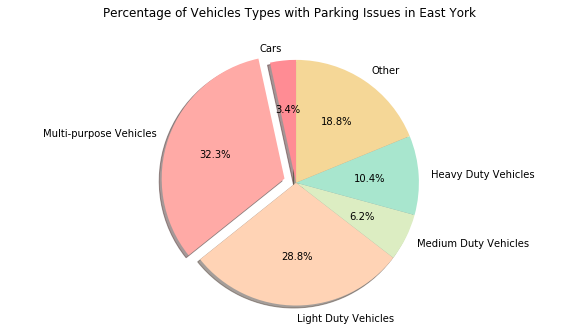

In [19]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[0]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0.1, 0, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in East York',pad = 30)
plt.show()

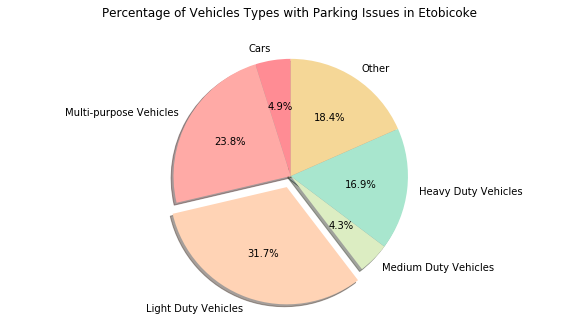

In [21]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[1]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in Etobicoke',pad = 30)
plt.show()

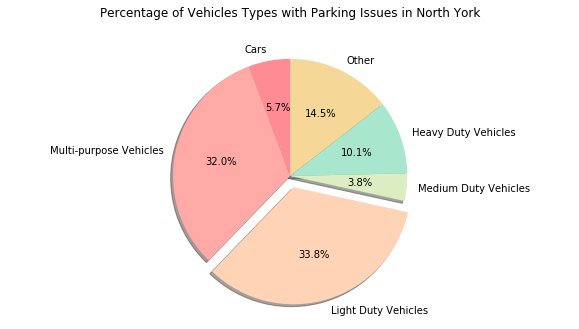

In [22]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[2]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in North York',pad = 30)
plt.show()

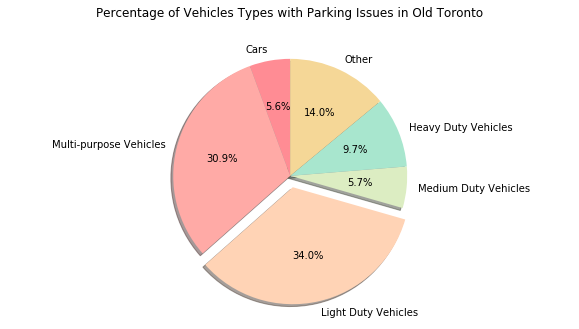

In [23]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[3]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in Old Toronto',pad = 30)
plt.show()

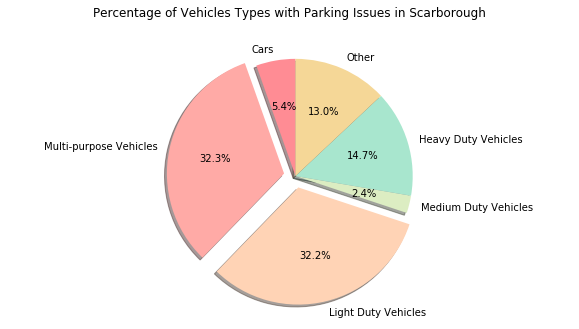

In [24]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[4]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0.1, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in Scarborough',pad = 30)
plt.show()

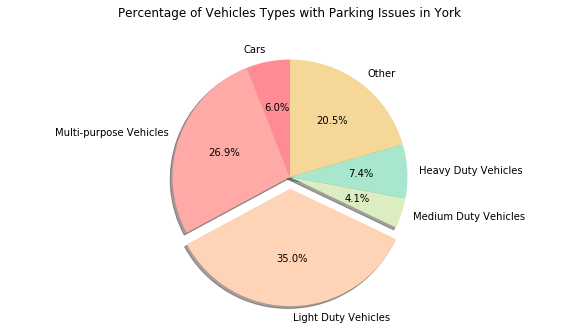

In [25]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[5]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in York',pad = 30)
plt.show()

### II. General organization: Where to place new parking facilities?

#### How does the average parking time vary for different districts?

The catplot gragh shows the average parking time comparing between each district. The average time in Old Toronto Area is around 6 mins.

<Figure size 720x360 with 0 Axes>

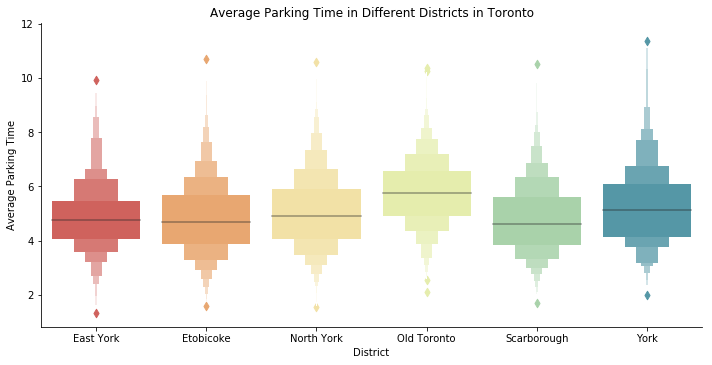

In [17]:
plt.figure(figsize=(10,5))
sns.catplot(x="District", y="AvgTimeToPark", kind="boxen",data=df_geotab.sort_values("District"),palette="Spectral",height=5,aspect=2)
plt.title('Average Parking Time in Different Districts in Toronto')
plt.xlabel('District')
plt.ylabel('Average Parking Time')
plt.show()

#### Which are the locations the vehicles spend most time in before finding a parking spot? 

This question can be tackled in two ways:
* **Issue Count Analysis**: the issue count is the count of parking geohashes in the city that have the percentage of vehicles searching for parking equal to or above the city average (based on the percentage of vehicles searching for parking from the Geotab data)
* **Circling distribution analysis**: the circling distribution will indicate the geohashes vehicles explore before parking and how long they spend in each neighboring geohash.

#### Issue Count Analysis

Shown below is Geotab Searching Parking dataset.

In [3]:
df_geotab.drop(df_geotab.columns[[7,8,9,10,11,27,28]], axis=1, inplace=True)
df_geotab.head()

,Geohash,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Latitude,Longitude,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,...,AvgTotalGeohashes,CirclingDistribution,HourlyDistribution,SearchingByHour,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,PercentOther
0,dpz2nth,43.62122,-79.51355,43.62259,-79.51218,43.62203,-79.51279,4.2656,1.4406,32,...,11.2500,"{""dpz2ntm"":0.1646, ""dpz2ntj"":0.0556, ""dpz2nt7""...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...",0.0000,0.1563,0.4375,0.0938,0.2188,0.0938
1,dpz2pnp,43.62671,-79.48746,43.62808,-79.48608,43.62777,-79.48653,6.5115,1.1102,58,...,9.5172,"{""dpz2pq0"":0.1145, ""dpz2pnp"":0.2925, ""dpz2pmb""...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...",0.0000,0.0000,0.0172,0.0000,0.8621,0.1207
2,dpz9k90,43.81897,-79.25537,43.82034,-79.25400,43.81917,-79.25500,4.4358,1.3241,40,...,7.2000,"{""dpz9k90"":0.3395, ""dpz9k8c"":0.0621, ""dpz9k3p""...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...",0.0000,0.0250,0.6000,0.0500,0.3250,0.0000
3,dpz95wt,43.80524,-79.29245,43.80661,-79.29108,43.80573,-79.29157,3.1831,1.0765,59,...,7.4407,"{""dpz95wv"":0.0873, ""dpz95ws"":0.0597, ""dpz95wq""...","{""00"": 0.0478, ""01"": 0, ""02"": 0.0478, ""03"": 0....","{""00"": 0.3333, ""01"": 0, ""02"": 0.1667, ""03"": 0....",0.1186,0.2542,0.2712,0.0000,0.3559,0.0000
4,dpz2jsn,43.61572,-79.55475,43.61710,-79.55338,43.61657,-79.55445,6.5225,1.6573,37,...,9.2973,"{""dpz2jez"":0.215, ""dpz2jsr"":0.0392, ""dpz2jsj"":...","{""00"": 0.0667, ""01"": null, ""02"": null, ""03"": 0...","{""00"": 0.4, ""01"": null, ""02"": null, ""03"": 0, ""...",0.0270,0.0811,0.5946,0.0270,0.1622,0.1081


Find the city average, only consider those geohashes have greater than 10 total searching.

In [5]:
AvgThreshold = df_geotab[df_geotab.TotalSearching > 10].PercentSearching.mean()
print("The average threshold is: ", str(AvgThreshold))

The average threshold is:  0.11617007779772592


We can define a parking lot that has parking issue when the searching time is larger than average.

In [6]:
df_issue = df_geotab[df_geotab.PercentSearching > AvgThreshold]

In [7]:
data = df_issue[['Geohash','PercentSearching','Latitude','Longitude']]
data['Value'] = data.apply(lambda row:[row.Latitude,row.Longitude,(row.PercentSearching-AvgThreshold)/0.1],axis = 1)
heatdata = data.Value.tolist()

We can then divide geohashes into six districts using geocode to convert coordinate to address

In [8]:
def re_geocode(coord):
    try:
        location = geolocator.reverse(coord,timeout = 10)
        return location.address.split(",")[-5]
    except GeocoderTimedOut:
        return re_geocode(coord)

In [ ]:
geolocator = Nominatim(user_agent="geotab")
district = []
for index, row in df_geotab.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    coord = "{},{}".format(lat,lon)
    dis = re_geocode(coord)
    district.append(dis)

In [10]:
# df_geotab['District'] = district
# df_geotab['District'] = df_geotab['District'].str.strip()
df_geotab = pd.read_csv("../data/SearchingParkingDistrict.csv")
df_geotab.head()

,Unnamed: 0,Geohash,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Latitude,Longitude,AvgTimeToPark,AvgTimeToParkRatio,...,CirclingDistribution,HourlyDistribution,SearchingByHour,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,PercentOther,District
0,0,dpz2nth,43.62122,-79.51355,43.62259,-79.51218,43.62203,-79.51279,4.2656,1.4406,...,"{""dpz2ntm"":0.1646, ""dpz2ntj"":0.0556, ""dpz2nt7""...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...",0.0000,0.1563,0.4375,0.0938,0.2188,0.0938,Etobicoke
1,1,dpz2pnp,43.62671,-79.48746,43.62808,-79.48608,43.62777,-79.48653,6.5115,1.1102,...,"{""dpz2pq0"":0.1145, ""dpz2pnp"":0.2925, ""dpz2pmb""...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...",0.0000,0.0000,0.0172,0.0000,0.8621,0.1207,Etobicoke
2,2,dpz9k90,43.81897,-79.25537,43.82034,-79.25400,43.81917,-79.25500,4.4358,1.3241,...,"{""dpz9k90"":0.3395, ""dpz9k8c"":0.0621, ""dpz9k3p""...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...",0.0000,0.0250,0.6000,0.0500,0.3250,0.0000,Scarborough
3,3,dpz95wt,43.80524,-79.29245,43.80661,-79.29108,43.80573,-79.29157,3.1831,1.0765,...,"{""dpz95wv"":0.0873, ""dpz95ws"":0.0597, ""dpz95wq""...","{""00"": 0.0478, ""01"": 0, ""02"": 0.0478, ""03"": 0....","{""00"": 0.3333, ""01"": 0, ""02"": 0.1667, ""03"": 0....",0.1186,0.2542,0.2712,0.0000,0.3559,0.0000,Scarborough
4,4,dpz2jsn,43.61572,-79.55475,43.61710,-79.55338,43.61657,-79.55445,6.5225,1.6573,...,"{""dpz2jez"":0.215, ""dpz2jsr"":0.0392, ""dpz2jsj"":...","{""00"": 0.0667, ""01"": null, ""02"": null, ""03"": 0...","{""00"": 0.4, ""01"": null, ""02"": null, ""03"": 0, ""...",0.0270,0.0811,0.5946,0.0270,0.1622,0.1081,Etobicoke


By counting the number of geohashes in each district, we get:

In [11]:
df_geotab.groupby('District')['Geohash'].count()

District
East York       113
Etobicoke       609
North York      776
Old Toronto    1469
Scarborough     593
York            171
Name: Geohash, dtype: int64

Then we can count the number of issues in each district:

In [12]:
df_dis = df_geotab.groupby('District')['PercentSearching'].apply(lambda x: (x > AvgThreshold).sum()).reset_index(name='IssueCount')
df_dis

,District,IssueCount
0,East York,44
1,Etobicoke,217
2,North York,287
3,Old Toronto,425
4,Scarborough,249
5,York,77


The bar plot below shows 6 districts ranked by the issue count:

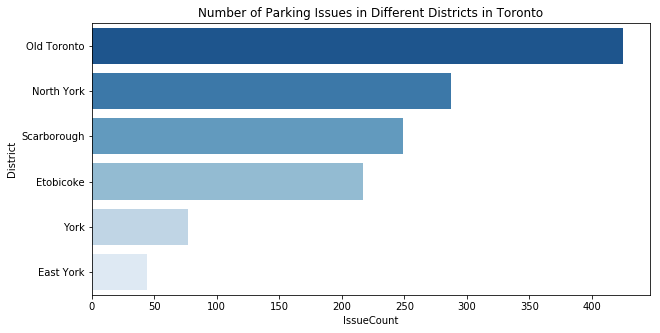

In [13]:
df_dis = df_dis.sort_values('IssueCount',ascending = False)
plt.figure(figsize=(10,5))
sns.barplot(x = df_dis.IssueCount,y = df_dis.District,data = df_dis, palette="Blues_r")
plt.title('Number of Parking Issues in Different Districts in Toronto')
plt.xlabel('IssueCount')
plt.ylabel('District')
plt.show()

We can also create a choropleth map to show the issue count in each district:

In [ ]:
shp = ps.open('../data/cityprj_former_municipality.shp')
dbf = ps.open('../data/cityprj_former_municipality.dbf')
city = fm.build_features(shp, dbf)

In [ ]:
with open('city.json', 'w') as out:
    gj.dump(city, out)

In [ ]:
df_dis['AREA_NAME'] = df_dis['District'].str.upper()
df_dis['AREA_NAME'][3] = "TORONTO"
df_dis

In [ ]:
m = folium.Map([43.6798, -79.4252], zoom_start = 12, tiles='openstreetmap')
folium.LatLngPopup().add_to(m)

In [ ]:
folium.Choropleth(
 geo_data = gdf,
 data = df_dis,
 columns=['AREA_NAME', 'IssueCount'],
 key_on='feature.properties.AREA_NAME',
 fill_color='YlGn',
 fill_opacity=0.5,
 line_opacity=0.7,
 legend_name='Parking Issue Count in Toronto'
).add_to(m)

In [ ]:
from folium.features import DivIcon
folium.map.Marker(
    [43.6499, -79.4288],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">Old Toronto</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.6683, -79.5900],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">Etobicoke</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.7516, -79.4864],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">North York</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.7938, -79.2812],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">Scarborough</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.6916, -79.4960],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">York</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.7055, -79.3643],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">East York</div>',
        )
    ).add_to(m)

The dark green means more parking issues. Old Toronto Area has bigger challenge in searching parking.

In [ ]:
m.save('city_data.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=city_data.html width=780 height=550></iframe>')

The heatmap shows the difference between percent driving and average threshold

In [ ]:
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 3,radius = 17).add_to(m)
m.save('plot_data.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=plot_data.html width=780 height=550></iframe>')

#### Circling distribution analysis

#### What's the average time spent in parking in a neighborhood geohash for a vehicle?

In [73]:
#Subsetting only for Circling Distribution Exploration
geoTabCircleDat=df_geotab[['Geohash','AvgTimeToPark','PercentSearching','CirclingDistribution']]

In [74]:
#Convert JSON string to dictionary
CirclingDistListDict = geoTabCircleDat.CirclingDistribution.apply(json.loads).values.tolist()

In [75]:
#Create dataframe of Circling distribution
geoCircleDict={"parkGeoHash":[],"spendGeoHash":[],"pctTimeSpend":[],"AvgTimeToPark":[],"PercentSearching":[]}
i=0
for geoCircle in CirclingDistListDict:
    geoCircleDict["parkGeoHash"].extend([geoTabCircleDat["Geohash"][i]]*len(geoCircle.keys()))
    geoCircleDict["spendGeoHash"].extend(list(geoCircle.keys()))
    geoCircleDict["pctTimeSpend"].extend(list(geoCircle.values()))
    geoCircleDict["AvgTimeToPark"].extend([geoTabCircleDat["AvgTimeToPark"][i]]*len(geoCircle.keys()))
    geoCircleDict["PercentSearching"].extend([geoTabCircleDat["PercentSearching"][i]]*len(geoCircle.keys()))
    i+=1
geoCircleDat=pd.DataFrame(geoCircleDict)

In [76]:
#This table shows us, how many different park neighborhoods does a vehicle spending most time in a spend neighborhood can go into and the average parking time of these park geohashes
#idx = geoCircleDat.groupby(['parkGeoHash'])['pctTimeSpend'].transform(max) == geoCircleDat['pctTimeSpend']
geoCircleDatAgg=geoCircleDat.groupby(["spendGeoHash"],as_index=False).agg({'parkGeoHash':'nunique','AvgTimeToPark':'mean'})
geoCircleDatAgg=geoCircleDat.groupby(["spendGeoHash"],as_index=False).agg({'parkGeoHash':'nunique','AvgTimeToPark':'mean'})

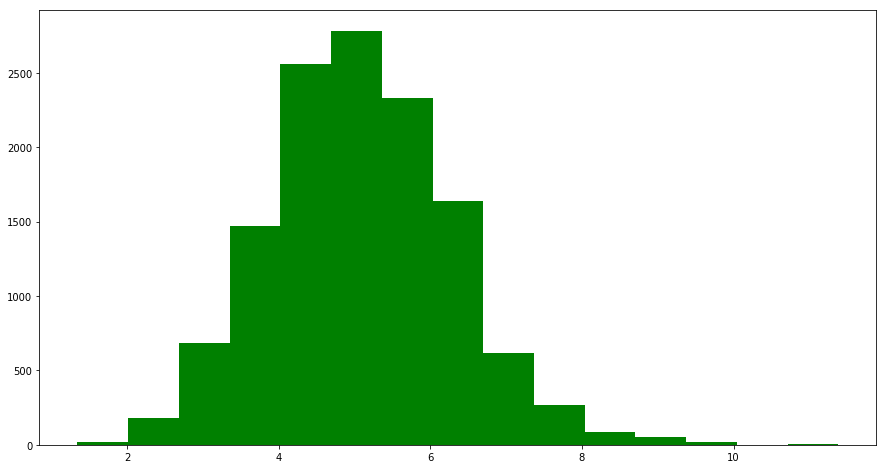

In [77]:
#Histogram of Avg. Parking time per park neighborhood
plt.figure(figsize=(15,8))
plt.hist(geoCircleDatAgg["AvgTimeToPark"],color="g",bins=15);

**Most vehicles spend 4-6 mins on an average in finding a parking spot at neighbor geohashes.**

#### What's the average number of neighorhood geohashes vehicles drive to find a parking?

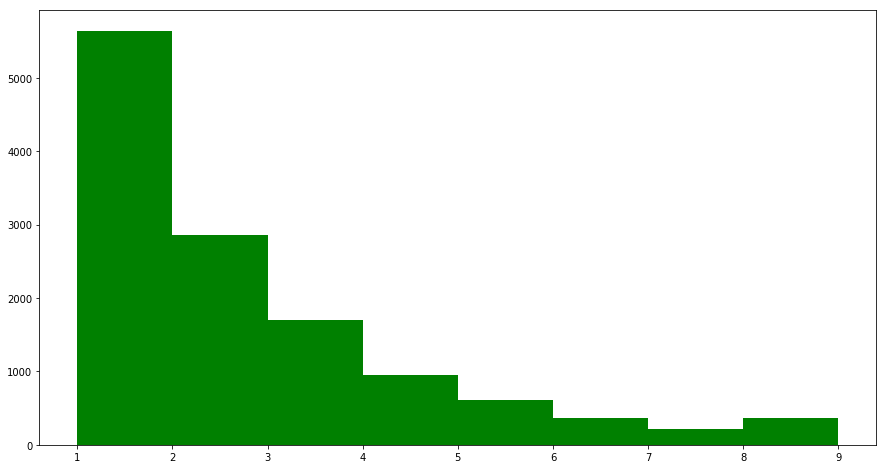

In [78]:
#Histogram of, # of different neighborhoods into which vehicles park at from a specific neighborhood 
plt.figure(figsize=(15,8))
plt.hist(geoCircleDatAgg["parkGeoHash"],color="g",bins=8);

**Most vehicles find a parking spot within circling upto two different neighborhoods. However, a fewer number of locations require vehicles to circle more than five different neighborhhods**

#### Is parking time more on neighborhoods than on own geohash?

For the purpose of this analysis, we only compare the average parking time across all different neighborhoods,vehicles at a specific geohas has driven to park and compare that against the 6 month average parking time for own geohash parking.

Parking Index= (Avg. Neighborhood GeoHash Avg. Parking Time)/(Avg. Current GeoHash Parking Time)

Note: For the purpose of the heatmap visualisation, we highlight every geohash with more than average ratio across the city.

In [79]:
geoCircleParkDatAgg=df_geotab.groupby(["Geohash"],as_index=False).agg({'AvgTimeToPark':'mean'})
geoCircleParkDatAgg.columns=["spendGeoHash","avgTimeToPark_parkGeoHash"]

In [80]:
geoCircleDatAgg['spend_lat'] = geoCircleDatAgg.apply(lambda row: pgh.decode(row.spendGeoHash)[0], axis = 1)
geoCircleDatAgg['spend_lng'] = geoCircleDatAgg.apply(lambda row: pgh.decode(row.spendGeoHash)[1], axis = 1)
geoCircleDatAgg=geoCircleDatAgg.merge(geoCircleParkDatAgg,on=['spendGeoHash'])

In [81]:
geoCircleDatAgg.columns=['spendGeoHash','no_of_parkGeoHash','avgParkTime_parkGeoHash','spend_lat','spend_lng','avgTimeToPark_spendGeoHash']

In [82]:
geoCircleDatAgg.head()

,spendGeoHash,no_of_parkGeoHash,avgParkTime_parkGeoHash,spend_lat,spend_lng,avgTimeToPark_spendGeoHash
0,dpxrvzm,3.631550,4,43.59,-79.54,2.5233
1,dpxrvzs,4.266050,2,43.59,-79.55,4.1580
2,dpxrvzt,3.631550,4,43.59,-79.54,4.3741
3,dpxrvzw,4.185500,4,43.59,-79.54,3.4708
4,dpxrvzz,4.358967,3,43.59,-79.54,6.3738


In [83]:
cmprParkTimeDat=geoCircleDatAgg[geoCircleDatAgg["avgTimeToPark_spendGeoHash"].notnull()]
cmprParkTimeDat['ownToNeighParkTimeIndex']=cmprParkTimeDat['avgParkTime_parkGeoHash']/cmprParkTimeDat['avgTimeToPark_spendGeoHash']

In [84]:
cmprParkTimeDat.head()

,spendGeoHash,no_of_parkGeoHash,avgParkTime_parkGeoHash,spend_lat,spend_lng,avgTimeToPark_spendGeoHash,ownToNeighParkTimeIndex
0,dpxrvzm,3.631550,4,43.59,-79.54,2.5233,1.585226
1,dpxrvzs,4.266050,2,43.59,-79.55,4.1580,0.481000
2,dpxrvzt,3.631550,4,43.59,-79.54,4.3741,0.914474
3,dpxrvzw,4.185500,4,43.59,-79.54,3.4708,1.152472
4,dpxrvzz,4.358967,3,43.59,-79.54,6.3738,0.470677


In [85]:
cmprParkTimeDat['ownToNeighParkTimeIndex_scaled']=(cmprParkTimeDat.ownToNeighParkTimeIndex-cmprParkTimeDat.ownToNeighParkTimeIndex.mean())/cmprParkTimeDat.ownToNeighParkTimeIndex.std()

In [86]:
# Create heatmap data
geoCirclehtMpDat = cmprParkTimeDat[['spendGeoHash','avgParkTime_parkGeoHash','spend_lat','spend_lng']]
geoCirclehtMpDat['avgParkTime_parkGeoHash_scaled']=(geoCirclehtMpDat['avgParkTime_parkGeoHash']-geoCirclehtMpDat['avgParkTime_parkGeoHash'].mean())/geoCirclehtMpDat['avgParkTime_parkGeoHash'].std()
geoCirclehtMpDat['Value'] = geoCirclehtMpDat.apply(lambda row: [row.spend_lat, row.spend_lng, row.avgParkTime_parkGeoHash_scaled], axis = 1)
heatdata = geoCirclehtMpDat.Value.tolist() # a list of lists: [[latitude, longitude, avg_per_neighbrohood],...]

# Define map 
heatmap = folium.Map([45.418167,-75.690994], tiles='openstreetmap', zoom_start=6)

# Plot Geohash Markers
Markers = folium.FeatureGroup(name='Circling GeoHash Distribution')

# Plot heatmap based on the Searching for Parking Index
index = folium.FeatureGroup(name='Geohash- Avg. Per Neigh')
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 1 ,radius=15).add_to(index) 
index.add_to(heatmap)
heatmap

**Average Parking Index Ratio:**

Most neighborhoods have similar park time as own location

In [87]:
cmprParkTimeDat.ownToNeighParkTimeIndex.mean()

0.7537056405846374

In [88]:
# Define map 
heatmap = folium.Map([45.418167,-75.690994], tiles='openstreetmap', zoom_start=6)

# Create heatmap data
cmprParkTimeHtMpDat = cmprParkTimeDat[['spendGeoHash','ownToNeighParkTimeIndex_scaled','spend_lat','spend_lng']]
cmprParkTimeHtMpDat['Value'] = cmprParkTimeHtMpDat.apply(lambda row: [row.spend_lat, row.spend_lng, row.ownToNeighParkTimeIndex_scaled], axis = 1)
heatdata = cmprParkTimeHtMpDat.Value.tolist() # a list of lists: [[latitude, longitude, avg_per_neighbrohood],...]

# Plot heatmap based on the Searching for Parking Index
OwnNeighborindex = folium.FeatureGroup(name='Own Vs Neighborhood Parking Index-GeoHash Level')
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 1 ,radius=15).add_to(OwnNeighborindex) 
OwnNeighborindex.add_to(heatmap)

# Add all the layers (feature groups) onto the map
folium.LayerControl().add_to(heatmap)
heatmap

As can be seen in most neighborhoods, vehicles spend as much time parking in circling area, as they would in currnet geohash zone.

In [89]:
# Compare to see if the difference in the two parking times are statistically significant
f_value, p_value = stats.f_oneway(cmprParkTimeDat['avgParkTime_parkGeoHash'],cmprParkTimeDat['avgTimeToPark_spendGeoHash'])

In [90]:
p_value

1.0724146950587426e-210

**A F-Test to test for difference between the park time in own and neighborhood zones suggest that the differences if any is not statistically signifcant**

In [92]:
geoCircleDat.columns=['parkGeoHash_AvgTimeToPark','parkGeoHash_PercentSearching', 'parkGeoHash','pctTimeSpend','spendGeoHash']

In [93]:
geoTabCircleDat=df_geotab[['Geohash','AvgTimeToPark','PercentSearching']]

In [94]:
geoTabCircleDat.columns=['spendGeoHash','spendGeoHash_AvgTimeToPark','spendGeoHash_PercentSearching']

In [95]:
geoCircleDat['spendGeoHash'].values

array(['dpz2nsv', 'dpz2nt7', 'dpz2ntk', ..., 'dpz2z80', 'dpz2xxc',
       'dpz2xxb'], dtype=object)

In [97]:
geoCircleDat = geoCircleDat.merge(geoTabCircleDat,on='spendGeoHash')

In [99]:
def find_distance(x):
    return pgh.geohash_approximate_distance(x[2],x[4])
geoCircleDat['distance']=geoCircleDat.apply(find_distance,axis=1)

In [100]:
#Decode Spend Geohash into latitude and longitude
geoCircleDat=pd.DataFrame(geoCircleDat)
geoCircleDat['spend_lat'] = geoCircleDat.apply(lambda row: pgh.decode(row.spendGeoHash)[0], axis = 1)
geoCircleDat['spend_lng'] = geoCircleDat.apply(lambda row: pgh.decode(row.spendGeoHash)[1], axis = 1)
geoCircleDat['park_lat'] = geoCircleDat.apply(lambda row: pgh.decode(row.parkGeoHash)[0], axis = 1)
geoCircleDat['park_lng'] = geoCircleDat.apply(lambda row: pgh.decode(row.parkGeoHash)[1], axis = 1)

In [101]:
geoCircleDat.head()

,parkGeoHash_AvgTimeToPark,parkGeoHash_PercentSearching,parkGeoHash,pctTimeSpend,spendGeoHash,spendGeoHash_AvgTimeToPark,spendGeoHash_PercentSearching,distance,spend_lat,spend_lng,park_lat,park_lng
0,4.2656,0.2645,dpz2nth,0.2464,dpz2nt7,5.0130,0.20,610,43.62,-79.51,43.62,-79.51
1,4.7185,0.0726,dpz2nt4,0.2150,dpz2nt7,5.0130,0.20,610,43.62,-79.51,43.62,-79.52
2,5.0130,0.2000,dpz2nt7,0.1660,dpz2nt7,5.0130,0.20,118,43.62,-79.51,43.62,-79.51
3,3.8219,0.0635,dpz2nt6,0.2743,dpz2nt7,5.0130,0.20,610,43.62,-79.51,43.62,-79.52
4,4.2656,0.2645,dpz2nth,0.1646,dpz2ntm,4.1833,0.12,610,43.62,-79.51,43.62,-79.51


In [103]:
food_shop_count=pd.read_csv("../data/Total food shop count.csv")

In [104]:
food_shop_count=food_shop_count[['Geohash','District','food_count','shop_count']].drop_duplicates(keep=False)

In [107]:
food_shop_count.columns=['spendGeoHash','spendDistrict','spendFoodC','spendShopC']
geoCircleDat=geoCircleDat.merge(food_shop_count,on='spendGeoHash')
food_shop_count.columns=['parkGeoHash','parkDistrict','parkFoodC','parkShopC']
geoCircleDat=geoCircleDat.merge(food_shop_count,on='parkGeoHash')
food_shop_count.columns=['Geohash','District','FoodC','ShopC']
geoTabDat=df_geotab.merge(food_shop_count,on='Geohash')

In [108]:
geoCircleDat.head()

,parkGeoHash_AvgTimeToPark,parkGeoHash_PercentSearching,parkGeoHash,pctTimeSpend,spendGeoHash,spendGeoHash_AvgTimeToPark,spendGeoHash_PercentSearching,distance,spend_lat,spend_lng,...,spendShopC_x,parkDistrict_x,parkFoodC_x,parkShopC_x,spendDistrict_y,spendFoodC_y,spendShopC_y,parkDistrict_y,parkFoodC_y,parkShopC_y
0,4.2656,0.2645,dpz2nth,0.2464,dpz2nt7,5.0130,0.2000,610,43.62,-79.51,...,5,Etobicoke,2,3,Etobicoke,5,5,Etobicoke,2,3
1,4.2656,0.2645,dpz2nth,0.1646,dpz2ntm,4.1833,0.1200,610,43.62,-79.51,...,8,Etobicoke,2,3,Etobicoke,9,8,Etobicoke,2,3
2,4.2656,0.2645,dpz2nth,0.1904,dpz2nth,4.2656,0.2645,118,43.62,-79.51,...,3,Etobicoke,2,3,Etobicoke,2,3,Etobicoke,2,3
3,4.7185,0.0726,dpz2nt4,0.2150,dpz2nt7,5.0130,0.2000,610,43.62,-79.51,...,5,Etobicoke,5,3,Etobicoke,5,5,Etobicoke,5,3
4,4.7185,0.0726,dpz2nt4,0.1224,dpz2nt3,2.4583,0.0763,610,43.62,-79.52,...,7,Etobicoke,5,3,Etobicoke,6,7,Etobicoke,5,3


#### Ranking based GeoHash Parking Suggestion:

In [109]:
def findPArkGeoHash(spendGeoHash):
    
    '''This function returns the Geohash that is best to park based on a simple ranking algorithm'''
    
    #Subset only those records relevant to spendGeoHash
    spendDat=geoTabDat
    spendDat['distance']=spendDat.apply(lambda row: pgh.geohash_approximate_distance(row.Geohash,spendGeoHash),axis=1)
    
    #Rank by distance
    spendDat['dRank']=spendDat['distance'].rank(ascending=True)
    
    #Rank by Avg. Time to Park
    spendDat['parkRank']=spendDat['AvgTimeToPark'].rank(ascending=True)
    
     #Rank by Percentage Searching for Parking
    spendDat['searchRank']=spendDat['PercentSearching'].rank(ascending=True)
    
    #Rank by Food and Shop Counts
    spendDat['foodRank']=spendDat['FoodC'].rank(ascending=True)
    
    #Rank by Food and Shop Counts
    spendDat['shopRank']=spendDat['ShopC'].rank(ascending=True)
    
    spendDat=spendDat.drop_duplicates(keep=False)
    
    spendDat['totalRank']=10*(spendDat['dRank']+spendDat['parkRank'])+5*(spendDat['searchRank'])+2.5*(spendDat['foodRank']+spendDat['shopRank'])
    
    
    #spendDat['totalRank']=spendDat['totalRank']/(4*len(spendDat['Geohash']))
    spendDat['parkGeoHash']=spendDat['Geohash']
    spendDat['spendGeoHash']=spendGeoHash
    
    #Retain only required columns
    spendDat=spendDat[['parkGeoHash','spendGeoHash','distance','AvgTimeToPark','PercentSearching','FoodC','ShopC','dRank','parkRank','searchRank','foodRank','shopRank','totalRank']].drop_duplicates(keep=False)
    
    return spendDat[spendDat['totalRank']==min(spendDat['totalRank'])]

In [110]:
#Find the best Geohash to park for each Geohash location, based on Rannking of distance, Parking Time, % vehicles searching for parking, # of food and shops
spendGeoHashes=geoCircleDat.spendGeoHash.unique()
Rank_geoCircleDat = pd.DataFrame()
for spendGeoHash in spendGeoHashes:
    Rank_geoCircleDat=Rank_geoCircleDat.append(findPArkGeoHash(spendGeoHash))
#findPArkGeoHash(spendGeoHash)

In [111]:
Rank_geoCircleDat.head()

,parkGeoHash,spendGeoHash,distance,AvgTimeToPark,PercentSearching,FoodC,ShopC,dRank,parkRank,searchRank,foodRank,shopRank,totalRank
3622,dpz2nnx,dpz2nt7,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2ntm,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2nth,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2nt3,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2nt4,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5


In [112]:
#Find the avg. park time it currently takes to find a parking spot, from each geo hash
actualParkTimeDat=geoCircleDat.groupby(by=['spendGeoHash'],as_index=False).agg({'parkGeoHash_AvgTimeToPark':'mean'})

In [113]:
#Compare the rank based recommendation with actual park time
compareActPredParkTime=actualParkTimeDat.merge(Rank_geoCircleDat[['parkGeoHash','spendGeoHash','AvgTimeToPark']],on='spendGeoHash')

In [114]:
compareActPredParkTime.columns=['spendGeoHash','Act_Avg_ParkTime','Rec_parkGeoHash','Rec_ParkTime']
compareActPredParkTime['RecnPerfIndex']=compareActPredParkTime['Rec_ParkTime']/compareActPredParkTime['Act_Avg_ParkTime']

In [115]:
compareActPredParkTime.head()

,spendGeoHash,Act_Avg_ParkTime,Rec_parkGeoHash,Rec_ParkTime,RecnPerfIndex
0,dpxrvzm,3.631550,dpxrvzm,2.5233,0.694827
1,dpxrvzs,4.266050,dpxrvzm,2.5233,0.591484
2,dpxrvzt,3.631550,dpxrvzm,2.5233,0.694827
3,dpxrvzw,4.185500,dpxrvzm,2.5233,0.602867
4,dpxrvzz,4.358967,dpxrvzm,2.5233,0.578876


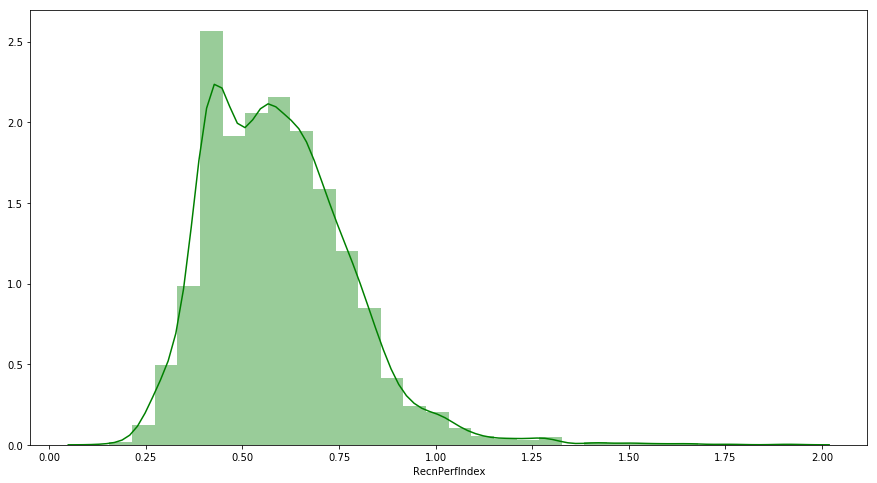

In [116]:
#Histogram of Ranking based GeoHash Park Time Vs Actual Geohash Park Time
plt.figure(figsize=(15,8))
sns.distplot(compareActPredParkTime["RecnPerfIndex"],bins=30,color="g");

Using a simple ranking algorithm of different features considered, our suggestion can lead to much reduced park time than the current scenario

In [117]:
# How does the recommended geohash compare to own geohash park time?
compareActPredParkTime=compareActPredParkTime.merge(geoTabDat[['Geohash','AvgTimeToPark']],left_on='spendGeoHash',right_on='Geohash')

In [118]:
compareActPredParkTime=compareActPredParkTime.drop(['Geohash'],axis=1)

In [119]:
compareActPredParkTime.columns=['spendGeoHash', 'Act_Avg_ParkTime', 'Rec_parkGeoHash', 'Rec_ParkTime','RecnPerfIndex', 'Own_AvgTimeToPark']

In [120]:
compareActPredParkTime['OwnRecnPerfIndex']=compareActPredParkTime['Rec_ParkTime']/compareActPredParkTime['Own_AvgTimeToPark']

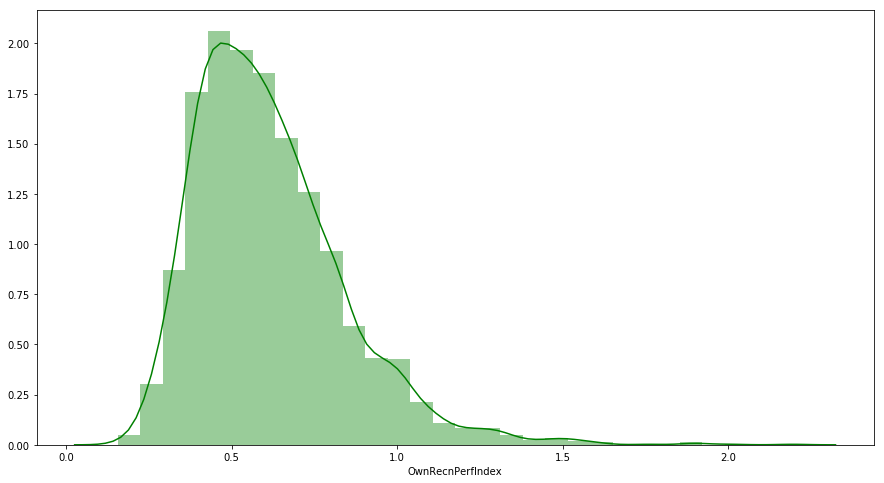

In [121]:
plt.figure(figsize=(15,8))
sns.distplot(compareActPredParkTime["OwnRecnPerfIndex"],bins=30,color="g");

In this case too, the ranking based geohash is much better than own geo hash park time

#### Will placing new parking facilities really result in decreasing the average searching for parking time ?

In [124]:
df_plf = pd.read_csv('parking_lot_facilities_cleaned.csv')

In [125]:
df_geotab = df_geotab.rename({'Geohash': 'geohash'}, axis=1)
df_merged = pd.merge(df_geotab, df_plf, on=['geohash'])

LinregressResult(slope=-0.002555056022344729, intercept=5.2255772982461774, rvalue=-0.18701907819383354, pvalue=0.4169350515824565, stderr=0.003078979100875691)

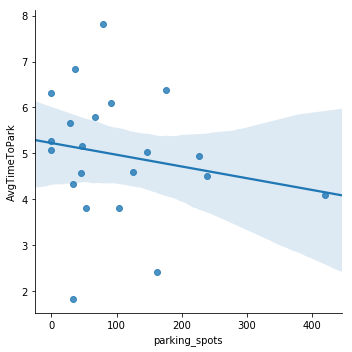

In [126]:
sns.lmplot(x='parking_spots', y='AvgTimeToPark', data=df_merged)
stats.linregress(df_merged['parking_spots'], df_merged['AvgTimeToPark'])

In this case, we can decide to remove the point at the rightmost part of the graph (seems like a outlier, having a very high number of parking spots).

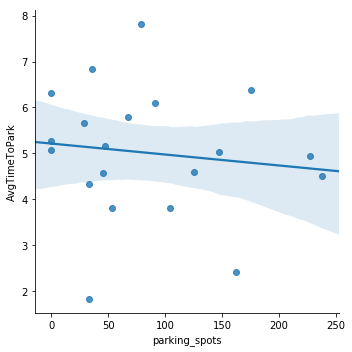

In [127]:
df_merged2 = df_merged[~df_merged.index.isin([11])]
sns.lmplot(x='parking_spots', y='AvgTimeToPark', data=df_merged2)

In [128]:
stats.linregress(df_merged2['parking_spots'], df_merged2['AvgTimeToPark'])

LinregressResult(slope=-0.002387964307803153, intercept=5.213952382224757, rvalue=-0.12284495290362585, pvalue=0.6058778031731202, stderr=0.004547077323085025)

In both cases, we can see that the results are not significant enough to conclude that more parking spots do not lead to a lower average parking time. We also looked at what happens when aggregating at a 6-character level.